# Extracting Data from the Binance Exchange by using Websockets

The current global cryptocurrency market is worth more than 1.5 trillion dolars. Cryptocurrencies have emerged from literally an asset with no profitable value such as the famous story where [a man has traded his 10,000 BTC for pizza](https://bitcointalk.org/index.php?topic=137.0) to an asset worth more than U$ 30,000 as of this date. It is no wonder that we can see a future marked by the usage of cryptocurrencies instead of the old fiat.

This tutorial is about how one can extract data from the Binance API available at [Binance API](https://www.binance.com/en/my/settings/api-management). This example uses the documentation available at [python-binance](https://python-binance.readthedocs.io/en/latest/index.html) and a few other tricks so we can accomplish our goals!

## Importing the Client and Setting API Key and API Secret
To access the Binance API, it is needed first to initialize the Client and then authenticate within the Binance API. This tutorial assumes you have already set the keys in a keys.ipynb file as below, which is located inside the same directory of the current Jupyter notebook file.
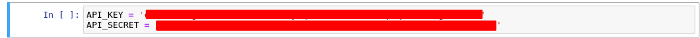

In [34]:
from binance.client import Client
# Get keys for usage with Binance API
%run keys.ipynb

# Initializes Client inside the client variable
client = Client(API_KEY,API_SECRET)

## Constants

**TRADING_PAIR** corresponds to the pair from which the Binance API will extract the data. In this case, the author has opted to select the pair of the ADA coin which is expressed in terms of the BNB coin.

**STARTING_DATE** is defined as the starting date for the samples for which the data will be gathered and **ENDING_DATE**, correspondingly, the ending date for these samples.

In [35]:
# Escolhe o par
TRADING_PAIR = 'ADABNB'
# Data de Inicio da Captura dos Dados
STARTING_DATE = "22 May, 2021"
# Data Final da Captura dos Dados
END_DATE = "23 May, 2021"

## Process Message Function
The Process Message function defines how the contents returned by the calls to the API will be processed. In our case, if there are any errors, the socket will stop connecting to the Binance API and close the Binance Socket Manager. Else, it will proceed with the operations.

In [36]:
def process_message(msg):
    if msg['e'] == 'error':
        bm.stop_socket(conn_key)
        bm.close()
    else:
        pass

## Binance Websockets
[Websockets](https://developer.mozilla.org/en-US/docs/Web/API/WebSockets_API) allow to open a two-way interactive communication session between the Jupyter environment and a server. With a Websockets API, Jupyter can send messages to a server and receive event-driven responses without having to poll the Binance API again for a reply.

First, we import the [Binance Websockets API](https://python-binance.readthedocs.io/en/latest/websockets.html) and initialize the [Binance Socket Manager](https://python-binance.readthedocs.io/en/latest/websockets.html#binancesocketmanager-websocket-usage) with an user timeout of 60 seconds. Then, we start a trading socket on the trading pair previously defined using the **Process Message Function**.

In [37]:
# Importing Binance Websockets API
from binance.client import *
from binance.websockets import BinanceSocketManager
from twisted.internet import reactor

# Initialize Binance Socket Manager
bm = BinanceSocketManager(client, user_timeout=60)
list_messages = []
conn_key = bm.start_trade_socket(TRADING_PAIR, process_message)
bm.start()

## Candlestick Data

In this example, the author has opted to approach only the values for the [Kline/Candlesticks Endpoint](https://python-binance.readthedocs.io/en/latest/market_data.html#id6), albeit the API has an [extensive amount of other endpoints for Market Data](https://python-binance.readthedocs.io/en/latest/market_data.html). The **TRADING_PAIR** ADA/BNB is used, as stated above, and the interval we have opted to choose was for 5M - or 5 minute - candles.

You can see the available intervals inside the [Constants](https://python-binance.readthedocs.io/en/latest/constants.html) for the Python wrapper for Binance API.

In [38]:
candles = client.get_klines(symbol=TRADING_PAIR, interval=Client.KLINE_INTERVAL_5MINUTE)

## Initializing the Data


Now the data is initialized by assigning the values for the indexes - or header columns - to an array and initialize the data from the candle data saved inside the *candles* variable into a Pandas DataFrame. Then, we'll show the first 5 columns of the DataFrame.

In [39]:
import pandas as pd

indexes = ['Open Time', 'Open', 'High','Low', 'Close', 'Volume', 'Close Time', 'QAV', 'No. Trades', 'Taker BBAV', 'Taker BQAV', 'Ignore']
data = pd.DataFrame(columns=indexes,data=candles)
data.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,QAV,No. Trades,Taker BBAV,Taker BQAV,Ignore
0,1621758600000,0.00505500,0.00506300,0.00501400,0.00504600,81838.00000000,1621758899999,412.45858000,263,29382.00000000,148.02874200,0
1,1621758900000,0.00504200,0.00506600,0.00500400,0.00500400,120175.00000000,1621759199999,605.99748800,348,53294.00000000,268.38967800,0
2,1621759200000,0.00501100,0.00502200,0.00498300,0.00500000,90252.00000000,1621759499999,451.05157900,268,21405.00000000,106.94323100,0
3,1621759500000,0.00500400,0.00502500,0.00498300,0.00498300,162699.00000000,1621759799999,814.71476800,370,84077.00000000,421.09383800,0
4,1621759800000,0.00499100,0.00499500,0.00493600,0.00494000,167842.00000000,1621760099999,833.68666400,512,53889.00000000,267.76022000,0


## Data Preprocessing
Fixing the wrong timestamp for the **Open Time** columns and setting this column as the index for the DataFrame is crucial for proper visualization of the DataFrame. Then, filtering out the columns so our DataFrame will only contain the **Open Time, Open, High, Low, Close and Volume** - ie. Open Time + OHLCV. 

In [40]:
from datetime import datetime
data['Open Time'] = data['Open Time'].apply(lambda x: datetime.fromtimestamp(int(x)/1000))
data.set_index(['Open Time'], inplace=True)
data = data.filter(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume'])

Then, again, the first 5 columns are shown with the data and columns fixed.

In [41]:
data.head()

,Open,High,Low,Close,Volume
Open Time,,,,,
2021-05-23 05:30:00,0.00505500,0.00506300,0.00501400,0.00504600,81838.00000000
2021-05-23 05:35:00,0.00504200,0.00506600,0.00500400,0.00500400,120175.00000000
2021-05-23 05:40:00,0.00501100,0.00502200,0.00498300,0.00500000,90252.00000000
2021-05-23 05:45:00,0.00500400,0.00502500,0.00498300,0.00498300,162699.00000000
2021-05-23 05:50:00,0.00499100,0.00499500,0.00493600,0.00494000,167842.00000000
